# Simple EDA

### 1. Import libraries

In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from hashlib import md5

import seaborn as sns
sns.set(style="whitegrid")

### 2. Define Training, Validation and Testing Paths

In [2]:
base_dir = '/kaggle/input/teeth-disease-dataset/Teeth_Dataset'
splits = ['Training', 'Validation', 'Testing']

# Paths to training, validation and testing folders
split_paths = {split: os.path.join(base_dir, split) for split in splits}
split_paths


{'Training': '/kaggle/input/teeth-disease-dataset/Teeth_Dataset/Training',
 'Validation': '/kaggle/input/teeth-disease-dataset/Teeth_Dataset/Validation',
 'Testing': '/kaggle/input/teeth-disease-dataset/Teeth_Dataset/Testing'}

### 3. Image count per class per split

In [3]:
def get_class_counts(split_path):
    counts = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

# Count classes in each data split
df_counts_split = []

for split, split_path in split_paths.items():
    counts = get_class_counts(split_path)
    df = pd.DataFrame(list(counts.items()), columns=['Class', 'Image Count'])
    df['Split'] = split
    df_counts_split.append(df)

df_all = pd.concat(df_counts_split)
df_all = df_all.sort_values(by=['Class', 'Image Count'], ascending=[True, False])
df_all


,Class,Image Count,Split
1,CaS,480,Training
1,CaS,160,Validation
1,CaS,160,Testing
3,CoS,450,Training
3,CoS,149,Validation
3,CoS,149,Testing
4,Gum,360,Training
4,Gum,120,Validation
4,Gum,120,Testing
5,MC,540,Training


### 4. Plot Class Dirstribution (Training / Validation / Testing)

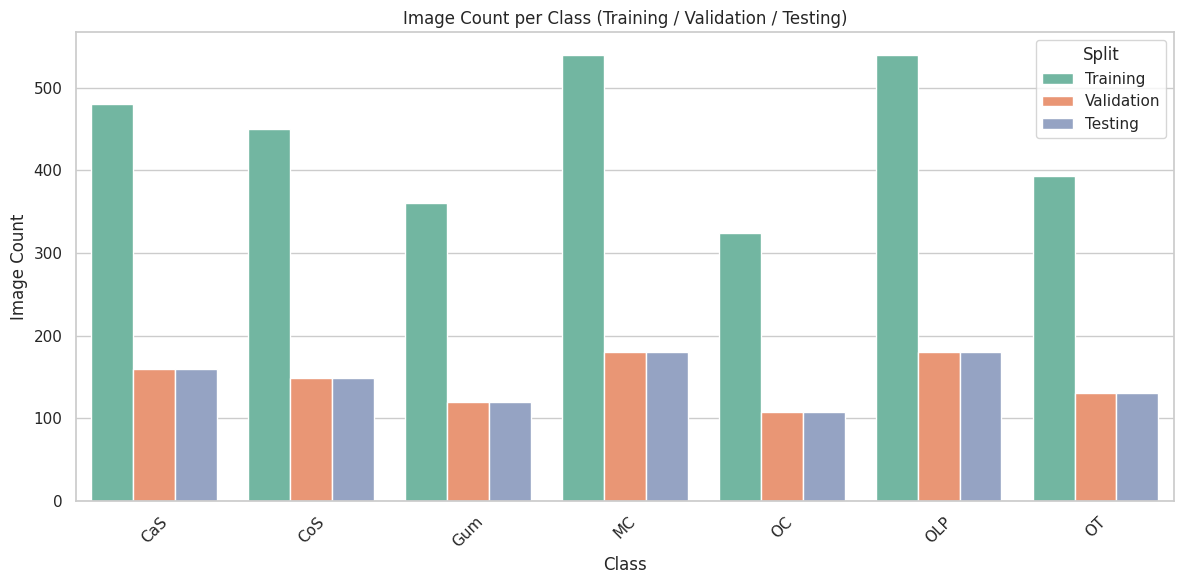

In [4]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x='Class', y='Image Count', hue='Split', palette='Set2')
plt.title('Image Count per Class (Training / Validation / Testing)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5. Plot Sample Images from Training Set

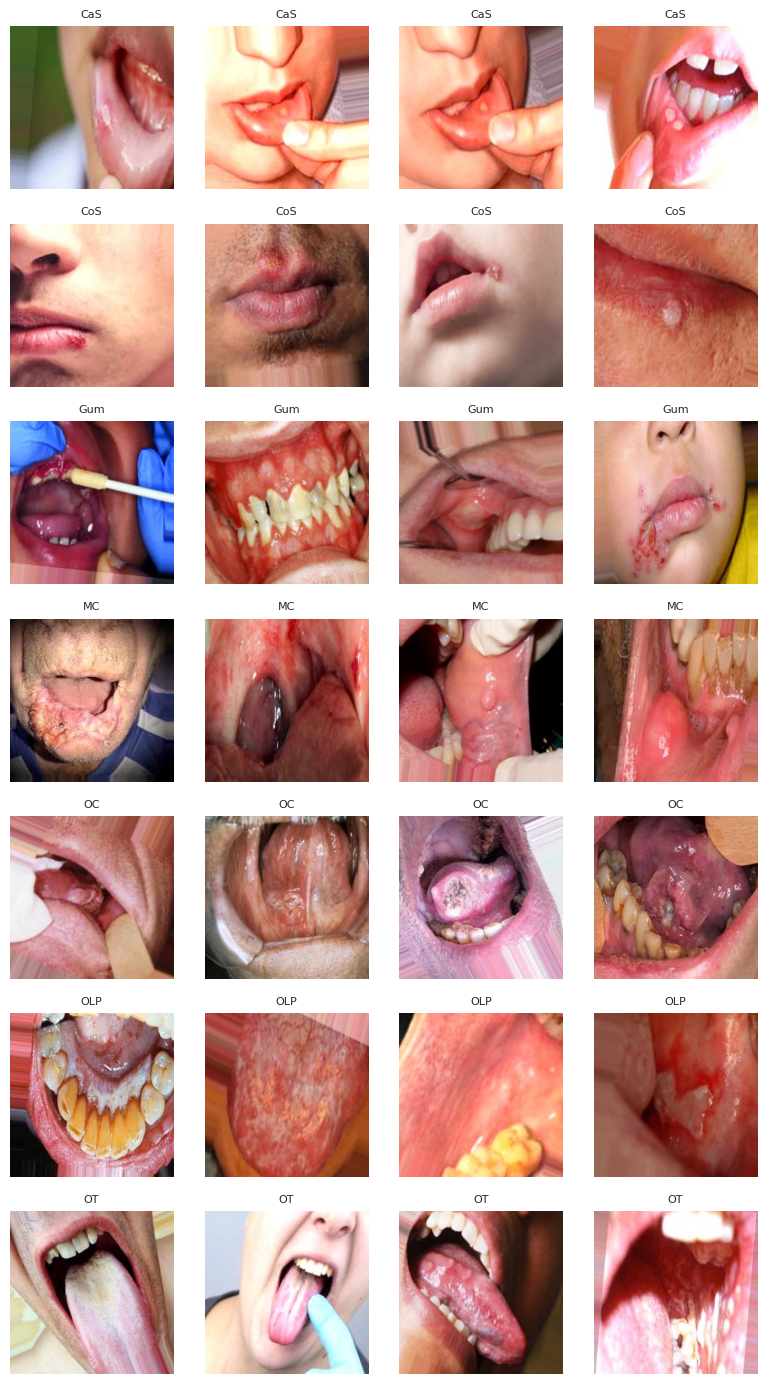

In [5]:
def plot_samples_from_split(split_dir, class_names, samples_per_class=4):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(split_dir, class_name)
        images = os.listdir(class_path)
        images_selected = random.sample(images, min(samples_per_class, len(images)))

        for j, img_name in enumerate(images_selected):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                plt.subplot(len(class_names), samples_per_class, i * samples_per_class + j + 1)
                plt.imshow(img)
                plt.title(class_name, fontsize=8)
                plt.axis('off')
            except:
                continue
    plt.tight_layout()
    plt.show()

# Plot samples from train set
plot_samples_from_split(split_paths['Training'], df_all['Class'].unique())


### 6. Check for Duplicates or Corrupt Images Across All Splits

In [6]:
def find_duplicates_and_corrupts(folder_path):
    hashes = set()
    duplicates = []
    corrupts = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with open(img_path, 'rb') as f:
                    img_hash = md5(f.read()).hexdigest()
                    if img_hash in hashes:
                        duplicates.append(img_path)
                    else:
                        hashes.add(img_hash)
            except:
                corrupts.append(img_path)
    return duplicates, corrupts

for split in splits:
    duplicates, corrupts = find_duplicates_and_corrupts(split_paths[split])
    print(f"{split.upper()} - Duplicates: {len(duplicates)}, Corrupt: {len(corrupts)}")

TRAINING - Duplicates: 12, Corrupt: 0
VALIDATION - Duplicates: 0, Corrupt: 0
TESTING - Duplicates: 2, Corrupt: 0


# Data Preprocessing

### 1. Load Data Splits (Training, Validation and Testing)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Constants
BATCH_SIZE = 64

train_data = image_dataset_from_directory(split_paths['Training'],
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        label_mode='categorical')

val_data = image_dataset_from_directory(split_paths['Validation'],
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      label_mode='categorical')

test_data = image_dataset_from_directory(split_paths['Testing'],
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       label_mode='categorical')


2025-07-11 10:52:36.968589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752231157.361235      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752231157.466120      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3087 files belonging to 7 classes.


I0000 00:00:1752231178.842595      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752231178.843430      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


### 2. Explore Images Shape

In [14]:
# Look on the First Batch
for images, labels in train_data.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

Images shape: (64, 256, 256, 3)
Labels shape: (64, 7)


### 3. Remove Duplicate Images

In [15]:
import hashlib

def hash_tensor(tensor):
    # Convert tensor to bytes and compute MD5 hash
    return hashlib.md5(tf.io.encode_jpeg(tf.cast(tensor, tf.uint8)).numpy()).hexdigest()

def remove_duplicates(dataset):
    seen_hashes = set()
    unique_data = []

    for images, labels in dataset.unbatch():
        image_hash = hash_tensor(images)
        if image_hash not in seen_hashes:
            seen_hashes.add(image_hash)
            unique_data.append((images, labels))

    # Convert list back to tf.data.Dataset and batch again
    images_cleaned, labels_cleaned = zip(*unique_data)
    dataset_cleaned = tf.data.Dataset.from_tensor_slices((list(images_cleaned), list(labels_cleaned)))
    dataset_cleaned = dataset_cleaned.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset_cleaned

train_data_cleaned = remove_duplicates(train_data)
val_data_cleaned = remove_duplicates(val_data)
test_data_cleaned = remove_duplicates(test_data)

# Check size of training data before and after
original_count = sum(1 for _ in train_data.unbatch())
cleaned_count = sum(1 for _ in train_data_cleaned.unbatch())
print(f"Removed {original_count - cleaned_count} duplicate images from training set.")

# Check size of validation data before and after
original_count = sum(1 for _ in val_data.unbatch())
cleaned_count = sum(1 for _ in val_data_cleaned.unbatch())
print(f"Removed {original_count - cleaned_count} duplicate images from validation set.")

# Check size of testing data before and after
original_count = sum(1 for _ in test_data.unbatch())
cleaned_count = sum(1 for _ in test_data_cleaned.unbatch())
print(f"Removed {original_count - cleaned_count} duplicate images from testing set.")

train_data = train_data_cleaned
val_data = val_data_cleaned
test_data = test_data_cleaned

Removed 12 duplicate images from training set.
Removed 0 duplicate images from validation set.
Removed 2 duplicate images from testing set.


### 4. Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

### 5. Normalization & Prefetch

In [17]:
# Normalize images to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)


# Build and Train the Model

### 1. Model Architecture

In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Explicit input shape
input_shape = (256, 256, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),

    data_augmentation,

    # Convolutional block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,199,687 (65.61 MB)

 Trainable params: 17,199,687 (65.61 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Train the Model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

EPOCHS = 50

history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS, callbacks=[early_stop])

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.1766 - loss: 1.9975 - val_accuracy: 0.2772 - val_loss: 1.8744
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.2590 - loss: 1.8586 - val_accuracy: 0.3444 - val_loss: 1.6844
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.3218 - loss: 1.7203 - val_accuracy: 0.3891 - val_loss: 1.5477
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.3940 - loss: 1.5992 - val_accuracy: 0.4504 - val_loss: 1.4121
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.4435 - loss: 1.4426 - val_accuracy: 0.4981 - val_loss: 1.3578
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.4811 - loss: 1.3753 - val_accuracy: 0.5661 - val_loss: 1.1843
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5115 - loss: 1.2794 - val_accuracy: 0.6342 - val_loss: 1.0719
Epoch 8/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.5668 - loss: 1.1647 - val_accuracy: 0.64

### 3. Visualizing the Model Results

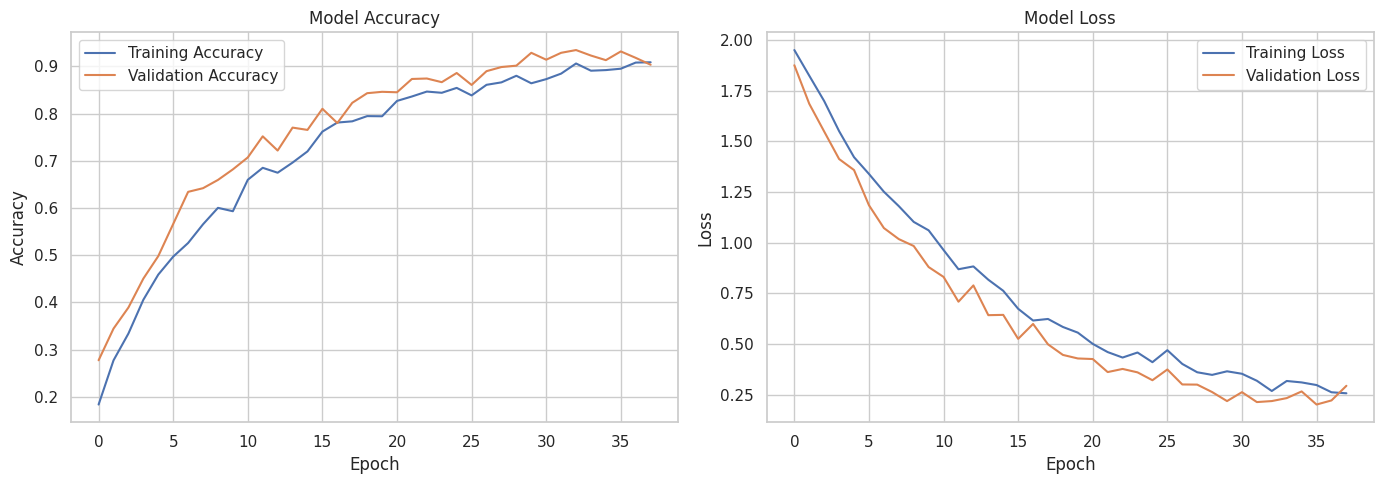

In [27]:
metrics_df = pd.DataFrame(model.history.history)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
axs[0].plot(metrics_df['accuracy'], label='Training Accuracy')
axs[0].plot(metrics_df['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Loss
axs[1].plot(metrics_df['loss'], label='Training Loss')
axs[1].plot(metrics_df['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### 4. Evaluate the Model

In [29]:
eval = model.evaluate(test_data)
print(f"Test accuracy: {eval[1]*100:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9434 - loss: 0.1858
Test accuracy: 92.69


### 5. Classification Report and Confusion Matrix

              precision    recall  f1-score   support

     Class 0       0.91      0.95      0.93       160
     Class 1       0.94      0.99      0.96       149
     Class 2       0.99      0.97      0.98       120
     Class 3       0.95      0.89      0.92       180
     Class 4       0.92      0.86      0.89       108
     Class 5       0.90      0.89      0.90       178
     Class 6       0.88      0.95      0.91       131

    accuracy                           0.93      1026
   macro avg       0.93      0.93      0.93      1026
weighted avg       0.93      0.93      0.93      1026



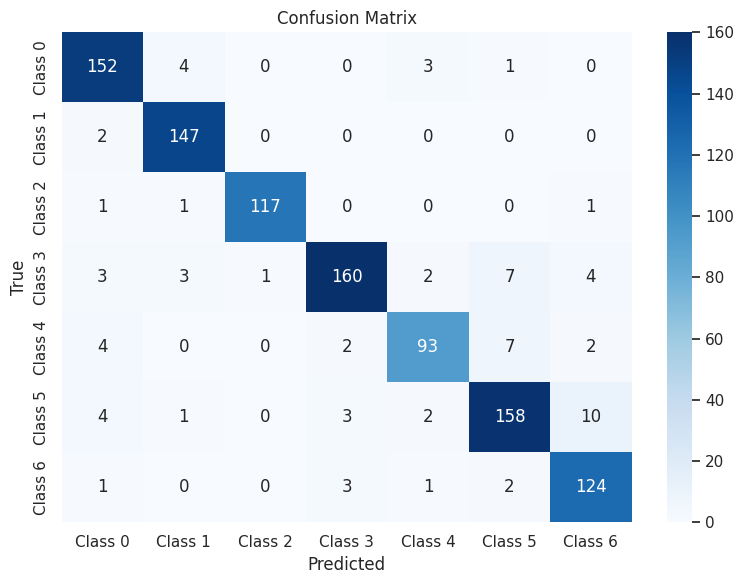

In [30]:
y_true = []
y_pred = []

for images, labels in test_data.unbatch():  # Unbatch to access single samples
    preds = model.predict(tf.expand_dims(images, 0), verbose=0)
    y_pred.append(np.argmax(preds))       # Predicted class index
    y_true.append(np.argmax(labels))      # True class index

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Optional: class names list
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6']

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### 6. Save the Model

In [31]:
model.save('teeth_disease_classifier_model.h5')

### 7. Download the Model

In [32]:
from IPython.display import FileLink

FileLink('teeth_disease_classifier_model.h5')

/kaggle/working/teeth_disease_classifier_model.h5